In [276]:
import numpy as np
import gym
import ppaquette_gym_doom
from ppaquette_gym_doom.wrappers import SetResolution, ToDiscrete
from gym.wrappers import SkipWrapper
from gym import wrappers

from scipy.misc import imresize
import types

def resize_observation_patch(env, size):
    """ Because unfortunately SetResolution also impacts the recorded videos...
    """
    original_reset = env.reset
    def reset_with_resized_obs(self):
        observation = original_reset()
        return imresize(observation, size)

    original_step = env.step
    def step_with_resized_obs(self, action):
        observation, reward, done, end = original_step(action)
        return imresize(observation, size), reward, done, end

    env.step = types.MethodType(step_with_resized_obs, env)
    env.reset = types.MethodType(reset_with_resized_obs, env)
    return env

WIDTH, HEIGHT = 84, 84

# (see https://github.com/ppaquette/gym-doom/blob/master/ppaquette_gym_doom/doom_basic.py)
def create_env(seed=None, monitor_directory=None, size=(WIDTH, HEIGHT)):
    env_spec = gym.spec('ppaquette/DoomDefendCenter-v0')
    env_spec.id = 'ppaquette/DoomDefendCenter-v0'
    env = env_spec.make()

    if seed is not None:
        env.seed(seed)

    if monitor_directory is not None:
        env = wrappers.Monitor(env, monitor_directory, force=True, mode='training')

    return resize_observation_patch(size=size,
                                    env=SkipWrapper(repeat_count=2)(ToDiscrete('minimal')(env)))

env = create_env()


NOOP, SHOOT, RIGHT, LEFT = 0, 1, 2, 3

(84, 84, 3)


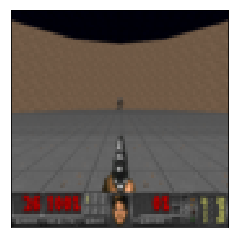

In [277]:
from matplotlib import pyplot as plt
%matplotlib inline

obs = env.reset()
obs, _, _, _ = env.step(action=1)

print(obs.shape)
def show(observation):
    plt.imshow(observation, interpolation=None)
    plt.xticks([]); plt.yticks([]);
    
show(obs)

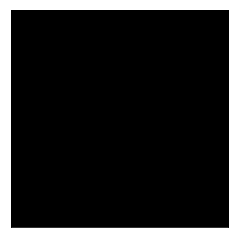

In [274]:
obs, _, _, _ = env.step(action=SHOOT)
show(obs)

## Collecting experiences

In [282]:
from collections import namedtuple
import operator

SARE = namedtuple('SAR', ['state', 'action', 'reward', 'end'])


def generate_sares(env, agent, episode_count=100):
    reward = 0
    done = False

    for i in range(episode_count):
        observation = env.reset()
        while True:
            action = agent.act(observation, reward, done)
            new_observation, reward, done, _ = env.step(action)
            yield SARE(observation, action, reward, done)
            
            if done:
                break
            else:
                observation = new_observation

def episode_sares(env, agent, episode_count=100):
    sares = list(generate_sares(env, agent, episode_count))
    print('average reward per episode = {}'.format(
        sum(r for _, _, r, _ in sares) / float(sum(e for _, _, _, e in sares))))
    return sares


def to_experiences(sares, only_n_misses=100):
    experiences = [
        (previous_s, a, r, next_s, end)
        for (previous_s, a, r, end), (next_s, _, _, _) in zip(sares[:-1], sares[1:])
    ]

    # simplistic experience prioritization
    shuffled_exps = experiences if only_n_misses is None\
        else random.choices(experiences, k=only_n_misses) + [e for e in experiences if e[2] > 0]
    random.shuffle(shuffled_exps)

    prev_frames, actions, rewards, next_frames, is_ends = zip(*shuffled_exps)
    prev_frames = np.asarray(prev_frames)
    next_frames = np.asarray(next_frames)
    actions = np.asarray(actions)
    rewards = np.asarray(rewards)
    is_ends = np.asarray(is_ends)

    print('Training on {}/{} positive/total out of {} 1-step experiences with actions distribution {}'.format(
        np.sum(rewards>=0),
        len(rewards),
        len(experiences),
        np.bincount(actions)))
    
    return (prev_frames, next_frames, actions, rewards, is_ends)

## Deep Q-learning

In [278]:
import tensorflow as tf
from keras import backend as K

from keras.layers import Dense, Convolution2D, Flatten, Activation
from keras.models import Sequential
from keras.optimizers import Adam

sess = tf.InteractiveSession()
K.set_session(sess)

def create_q_model(conv1_weights=None, conv2_weights=None, dense1_weights=None, dense2_weights=None):
    model = Sequential()

    model.add(
        Convolution2D(nb_filter=8, nb_row=3, nb_col=3, subsample=(2, 2), border_mode='valid', weights=conv1_weights,
            input_shape=[HEIGHT, WIDTH, 3], dim_ordering='tf'))
    model.add(Activation('relu'))
    model.add(
        Convolution2D(nb_filter=8, nb_row=2, nb_col=2, weights=conv2_weights))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(128, init='normal', weights=dense1_weights))
    model.add(Activation('relu'))
    model.add(Dense(4, init='normal', weights=dense2_weights))
    model.compile(loss='mse', optimizer=Adam())
    
    return model

acting_model = create_q_model()
target_model = create_q_model()

def copy_model(model):
    conv1_weights =  [w.eval() for w in model.layers[0].weights]
    conv2_weights = [w.eval() for w in model.layers[2].weights]
    dense1_weights = [w.eval() for w in model.layers[5].weights]
    dense2_weights = [w.eval() for w in model.layers[7].weights]
    return create_q_model(conv1_weights, conv2_weights, dense1_weights, dense2_weights)

Using TensorFlow backend.


In [279]:
class DeepQNetworkTrainer:
    
    MINI_BATCH_SIZE = 32
    UPDATE_TARGET_EVERY_N_BACTHES = 2
    
    def __init__(self, acting_model, target_model, double_q=False, gamma=.99, reward_clip=5, only_n_negative_experiences=100):
        self.acting_model = acting_model
        self.target_model = target_model
        self.double_q = double_q
        
        self.gamma = gamma
        self.reward_clip = reward_clip
        # basic experience prioritization 
        self.only_n_negative_experiences = only_n_negative_experiences

        # counter to periodically set target_model <- acting_model
        self.trained_epochs = 0
    
    def fit_episodes(self, sares):
        prev_frames, target_action_rewards = self._sares_to_input_targets(sares, double_q=self.double_q)
        self.acting_model.fit(x=prev_frames, y=target_action_rewards, batch_size=self.MINI_BATCH_SIZE, nb_epoch=1, verbose=0)
        self.trained_epochs += 1

        if (self.trained_epochs % self.UPDATE_TARGET_EVERY_N_BACTHES) == 0:
            self.target_model = copy_model(self.acting_model)

    def _sares_to_input_targets(self, sares, double_q=False):
        
        prev_frames, next_frames, actions, rewards, is_ends = to_experiences(sares, self.only_n_negative_experiences)
        n_samples = prev_frames.shape[0]

        clipped_rewards = np.clip(rewards, -np.inf, self.reward_clip)
    
        if double_q:
            greedy_actions = self.acting_model.predict(next_frames).argmax(axis=1)
            actions_target_values = self.target_model.predict(next_frames)[np.arange(n_samples), greedy_actions]            
            targets = clipped_rewards + self.gamma * (1 - is_ends) * actions_target_values
        else:
            # Transcription of the Q-learning target formula
            targets = clipped_rewards + self.gamma * (1 - is_ends) * self.target_model.predict(next_frames).max(axis=1)

        target_action_rewards = self.target_model.predict(prev_frames)
        target_action_rewards[np.arange(n_samples), actions] = targets

        return prev_frames, target_action_rewards


## Training

In [283]:
import random

class EpsilonGreedyQAgent(object):
    def __init__(self, model, epsilon=.1):
        self.model = model
        self.epsilon = epsilon

    def act(self, observation, reward, done):
        if random.uniform(0, 1) <= self.epsilon:
            return random.choice([NOOP, SHOOT, LEFT, RIGHT])
        else:
            return self.model.predict(observation[np.newaxis])[0].argmax()


N_BATCHES = 600
N_BATCHED_EPISODES = 10
directory = 'tmp/DoomDefendLine_q_learning'

env = create_env(monitor_directory=directory)

trainer = DeepQNetworkTrainer(acting_model, target_model, double_q=True)
for _ in range(N_BATCHES):
    sares = episode_sares(env, EpsilonGreedyQAgent(trainer.acting_model, epsilon=.1), N_BATCHED_EPISODES)
    trainer.fit_episodes(sares)

# final greedy episodes
sares = episode_sares(env, EpsilonGreedyQAgent(trainer.acting_model, epsilon=0), episode_count=1000)

env.close()
gym.upload(directory, api_key='sk_bNZUvCfkTfabQCoKoKbjFA')

[2017-03-11 12:47:43,509] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-03-11 12:47:43,874] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomDefendLine_q_learning/openaigym.video.2.17465.video000000.mp4
Exception ignored in: <bound method Env.__del__ of <SkipWrapper<ToDiscreteWrapper<_Monitor<TimeLimit<DoomDefendCenterEnv instance>>>>>>
Traceback (most recent call last):
  File "/Users/gui/.virtualenvs/gui3/lib/python3.6/site-packages/gym/core.py", line 252, in __del__
    self.close()
  File "/Users/gui/.virtualenvs/gui3/lib/python3.6/site-packages/gym/core.py", line 190, in close
    self._close()
  File "/Users/gui/.virtualenvs/gui3/lib/python3.6/site-packages/gym/core.py", line 346, in _close
    return self.env.close()
  File "/Users/gui/.virtualenvs/gu

average reward per episode = -0.5
Training on 105/105 positive/total out of 1062 1-step experiences with actions distribution [ 3  3 96  3]


Exception ignored in: <bound method Env.__del__ of <SkipWrapper<ToDiscreteWrapper<_Monitor<TimeLimit<DoomDefendCenterEnv instance>>>>>>
Traceback (most recent call last):
  File "/Users/gui/.virtualenvs/gui3/lib/python3.6/site-packages/gym/core.py", line 252, in __del__
    self.close()
  File "/Users/gui/.virtualenvs/gui3/lib/python3.6/site-packages/gym/core.py", line 190, in close
    self._close()
  File "/Users/gui/.virtualenvs/gui3/lib/python3.6/site-packages/gym/core.py", line 346, in _close
    return self.env.close()
  File "/Users/gui/.virtualenvs/gui3/lib/python3.6/site-packages/gym/core.py", line 190, in close
    self._close()
  File "/Users/gui/.virtualenvs/gui3/lib/python3.6/site-packages/gym/core.py", line 346, in _close
    return self.env.close()
  File "/Users/gui/.virtualenvs/gui3/lib/python3.6/site-packages/gym/core.py", line 190, in close
    self._close()
  File "/Users/gui/.virtualenvs/gui3/lib/python3.6/site-packages/gym/wrappers/monitoring.py", line 38, in _clo

average reward per episode = 0.6
Training on 116/116 positive/total out of 1035 1-step experiences with actions distribution [  6 104   2   4]


[2017-03-11 12:48:19,526] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomDefendLine_q_learning/openaigym.video.2.17465.video000027.mp4


average reward per episode = -0.7
Training on 102/103 positive/total out of 940 1-step experiences with actions distribution [96  3  1  3]
average reward per episode = -0.2
Training on 107/108 positive/total out of 967 1-step experiences with actions distribution [97  4  2  5]
average reward per episode = 0.0
Training on 109/110 positive/total out of 988 1-step experiences with actions distribution [97  4  7  2]
average reward per episode = -0.1
Training on 106/109 positive/total out of 993 1-step experiences with actions distribution [78 23  8]


[2017-03-11 12:48:57,583] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomDefendLine_q_learning/openaigym.video.2.17465.video000064.mp4


average reward per episode = -0.2
Training on 105/108 positive/total out of 957 1-step experiences with actions distribution [92  5  9  2]
average reward per episode = -0.8
Training on 101/102 positive/total out of 924 1-step experiences with actions distribution [92  2  5  3]
average reward per episode = -0.2
Training on 108/108 positive/total out of 979 1-step experiences with actions distribution [93  5  6  4]
average reward per episode = -0.6
Training on 104/104 positive/total out of 891 1-step experiences with actions distribution [93  3  7  1]
average reward per episode = 0.2
Training on 111/111 positive/total out of 1047 1-step experiences with actions distribution [94  7  9  1]
average reward per episode = -0.2
Training on 108/108 positive/total out of 1009 1-step experiences with actions distribution [80  9 16  3]


[2017-03-11 12:50:09,028] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomDefendLine_q_learning/openaigym.video.2.17465.video000125.mp4


average reward per episode = -0.4
Training on 104/106 positive/total out of 986 1-step experiences with actions distribution [88  5 11  2]
average reward per episode = -0.7
Training on 102/103 positive/total out of 934 1-step experiences with actions distribution [77  4 18  4]
average reward per episode = -0.1
Training on 109/109 positive/total out of 942 1-step experiences with actions distribution [93  3 10  3]
average reward per episode = 0.3
Training on 113/113 positive/total out of 1014 1-step experiences with actions distribution [91 11  8  3]
average reward per episode = -0.6
Training on 102/104 positive/total out of 972 1-step experiences with actions distribution [75  8 18  3]
average reward per episode = -0.2
Training on 108/108 positive/total out of 1045 1-step experiences with actions distribution [85  6 14  3]
average reward per episode = -0.3
Training on 106/107 positive/total out of 990 1-step experiences with actions distribution [77 12 15  3]
average reward per episode

[2017-03-11 12:51:40,859] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomDefendLine_q_learning/openaigym.video.2.17465.video000216.mp4


average reward per episode = -0.5
Training on 105/105 positive/total out of 992 1-step experiences with actions distribution [77  8 17  3]
average reward per episode = 0.0
Training on 110/110 positive/total out of 1058 1-step experiences with actions distribution [77 16 14  3]
average reward per episode = -0.5
Training on 102/105 positive/total out of 972 1-step experiences with actions distribution [77 12 15  1]
average reward per episode = -0.2
Training on 108/108 positive/total out of 1037 1-step experiences with actions distribution [85  8 14  1]
average reward per episode = -0.1
Training on 106/109 positive/total out of 958 1-step experiences with actions distribution [86  8  9  6]
average reward per episode = -0.5
Training on 104/105 positive/total out of 1013 1-step experiences with actions distribution [69 15 19  2]
average reward per episode = 0.9
Training on 119/119 positive/total out of 1260 1-step experiences with actions distribution [56 19 42  2]
average reward per episod

[2017-03-11 12:54:13,797] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomDefendLine_q_learning/openaigym.video.2.17465.video000343.mp4


average reward per episode = 1.1
Training on 121/121 positive/total out of 1185 1-step experiences with actions distribution [52 15 47  7]
average reward per episode = 2.0
Training on 130/130 positive/total out of 1476 1-step experiences with actions distribution [39 35 55  1]
average reward per episode = 0.9
Training on 119/119 positive/total out of 1194 1-step experiences with actions distribution [42 25 50  2]
average reward per episode = -0.4
Training on 105/106 positive/total out of 967 1-step experiences with actions distribution [72 20 13  1]
average reward per episode = 0.9
Training on 119/119 positive/total out of 1153 1-step experiences with actions distribution [10 31 74  4]
average reward per episode = 1.4
Training on 123/124 positive/total out of 1287 1-step experiences with actions distribution [ 9 36 75  4]
average reward per episode = 1.4
Training on 124/124 positive/total out of 1393 1-step experiences with actions distribution [20 39 64  1]
average reward per episode 

[2017-03-11 12:57:52,579] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomDefendLine_q_learning/openaigym.video.2.17465.video000512.mp4


average reward per episode = 0.2
Training on 111/112 positive/total out of 1075 1-step experiences with actions distribution [64 29 15  4]
average reward per episode = 1.4
Training on 122/123 positive/total out of 1207 1-step experiences with actions distribution [15 33 73  2]
average reward per episode = 0.9
Training on 118/119 positive/total out of 1237 1-step experiences with actions distribution [25 25 63  6]
average reward per episode = 0.9
Training on 119/119 positive/total out of 1309 1-step experiences with actions distribution [12 42 62  3]
average reward per episode = 0.6
Training on 115/116 positive/total out of 1146 1-step experiences with actions distribution [16 36 60  4]
average reward per episode = 2.0
Training on 129/129 positive/total out of 1373 1-step experiences with actions distribution [26 47 51  5]
average reward per episode = 0.8
Training on 117/118 positive/total out of 1276 1-step experiences with actions distribution [21 28 63  6]
average reward per episode 

[2017-03-11 13:03:08,771] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomDefendLine_q_learning/openaigym.video.2.17465.video000729.mp4


average reward per episode = 1.4
Training on 124/124 positive/total out of 1117 1-step experiences with actions distribution [28 45 28 23]
average reward per episode = 0.7
Training on 116/117 positive/total out of 1031 1-step experiences with actions distribution [43 42 21 11]
average reward per episode = 0.3
Training on 112/113 positive/total out of 1192 1-step experiences with actions distribution [19 50 25 19]
average reward per episode = 2.1
Training on 130/130 positive/total out of 1365 1-step experiences with actions distribution [14 62 43 11]
average reward per episode = 1.3
Training on 123/123 positive/total out of 1042 1-step experiences with actions distribution [23 61 28 11]
average reward per episode = 1.8
Training on 128/128 positive/total out of 1213 1-step experiences with actions distribution [20 47 37 24]
average reward per episode = 1.0
Training on 120/120 positive/total out of 1271 1-step experiences with actions distribution [13 70 30  7]
average reward per episode 

KeyboardInterrupt: 